In [1]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

'Working directory: /Users/hcha9747/workspace/juxtorpus'

In [2]:
import colorlog
from juxtorpus import rlogger

rlogger.setLevel(colorlog.INFO)

In [3]:
from juxtorpus.corpus import Corpus, CorpusBuilder

import re

tweet_wrapper = re.compile(r'([ ]?<[/]?TWEET>[ ]?)')

builder = CorpusBuilder('./tests/assets/Geolocated_places_climate_with_LGA_and_remoteness_0.csv')
builder.set_text_column('processed_text')
# builder.set_nrows(None)
builder.set_preprocessors([lambda text: tweet_wrapper.sub('', text)])
builder.add_metas('tweet_lga')
builder.add_metas(['year', 'month', 'day'], dtypes='datetime')
builder.add_metas('year_month_day', dtypes='datetime')    # this replaces year_month_day - only one column may be datetime.
display(builder.show_columns())
corpus = builder.build()
corpus.summary()

[INFO] You are using a multi-columned datetime. These columns will combined into a single 'datetime' meta.


,Add
All Columns,
year,True
month,True
tweet_lga,True
year_month_day,True
day,True
lon_mid,False
screen_name,False
tweet_id,False
retweet,False


Number of words           236056
Number of unique words     22456
Number of documents        10000
Name: frequency, dtype: uint64

In [4]:
corpus.metas()

frozendict.frozendict({'tweet_lga': <SeriesMeta [Id: tweet_lga]>, 'datetime': <SeriesMeta [Id: datetime]>, 'year': <SeriesMeta [Id: year]>, 'month': <SeriesMeta [Id: month]>, 'day': <SeriesMeta [Id: day]>, 'year_month_day': <SeriesMeta [Id: year_month_day]>})

In [5]:
corpus.get_meta('datetime').series().describe(datetime_is_numeric=True)

count                            10000
mean     2020-06-08 05:05:51.360000256
min                2019-11-11 00:00:00
25%                2019-12-22 00:00:00
50%                2020-02-03 00:00:00
75%                2020-11-08 00:00:00
max                2022-04-12 00:00:00
Name: datetime, dtype: object

In [6]:
from juxtorpus.corpus import CorpusSlicer
slicer = CorpusSlicer(corpus)
corpus = slicer.filter_by_item('tweet_lga', ['Sunshine Coast (R)', 'Broken Hill (C)'])
corpus.summary()   # only with Sunshine Coast & Broken Hill

Number of words           7815
Number of unique words    2090
Number of documents        549
Name: frequency, dtype: uint64

In [7]:
corpus.metas().keys()

dict_keys(['tweet_lga', 'datetime', 'year', 'month', 'day', 'year_month_day'])

In [8]:
# set up spacy nlp pipeline
from juxtorpus.corpus.processors import SpacyProcessor
import spacy

import transformers
transformers.logging.set_verbosity_error()

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('extract_hashtags')
nlp.add_pipe('extract_mentions')
nlp.add_pipe('extract_sentiments')
# nlp.remove_pipe('extract_sentiments')
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x16a187e20>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x16a187ee0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x16a186510>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x16a1c8e00>),
 ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x16a4a66c0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x16a1866d0>),
 ('extract_hashtags',
  <juxtorpus.corpus.processors.components.hashtags.HashtagComponent at 0x15fdc5160>),
 ('extract_mentions',
  <juxtorpus.corpus.processors.components.mentions.MentionsComp at 0x169a1ef10>),
 ('extract_sentiments',
  <juxtorpus.corpus.processors.components.sentiment.SentimentComp at 0x16a7427f0>)]

In [9]:
# Let's process this subset
spacy_processor = SpacyProcessor(nlp)
corpus = spacy_processor.run(corpus)

corpus.metas().keys()

[INFO] Processing corpus of 549 documents...


0it [00:00, ?it/s]

[INFO] Loading sentiment model: cardiffnlp/twitter-roberta-base-sentiment-latest... Please wait.
[INFO] Successfully loaded.
[INFO] Done.


dict_keys(['tweet_lga', 'datetime', 'year', 'month', 'day', 'year_month_day', 'ner', 'extract_hashtags', 'extract_mentions', 'extract_sentiments'])

In [10]:
corpus.texts()[:5]

6156                                    (@Jessroebot, \n)
6157             (Always, have, and, always, will, !, \n)
6158    (Rationalising, catastrophes, is, maladaptive,...
6159    (Eileen, ,, climate, change, produces, extreme...
6160    (Stop, rationalising, Eileen, !, FACE, REALITY...
Name: text, dtype: object

In [11]:
doc_iter = iter(corpus)
next(doc_iter)
doc = next(doc_iter)
doc.text, doc._.sentiment

('Always have and always will!\n',
 {'Positive': 0.8637, 'Neutral': 0.1212, 'Negative': 0.0151})

In [12]:
mentions = corpus.get_meta('extract_mentions')
mentions.head(25).iloc[13].text

'The Top HSC STUDENT WAS A CLIMATE STRIKER! @ScottMorrisonMP @GladysB\n'

In [13]:
political_figures = CorpusSlicer(corpus).filter_by_item('extract_mentions', ['@ScottMorrisonMP', '@AdamBandt'])
len(political_figures)

10

In [14]:
slicer = CorpusSlicer(political_figures)

positives = slicer.filter_by_condition('extract_sentiments', lambda sent_dict: max(sent_dict, key=sent_dict.get) == 'Positive')
neutrals = slicer.filter_by_condition('extract_sentiments', lambda sent_dict: max(sent_dict, key=sent_dict.get) == 'Neutral')
negatives = slicer.filter_by_condition('extract_sentiments', lambda sent_dict: max(sent_dict, key=sent_dict.get) == 'Negative')
len(positives), len(neutrals), len(negatives)

(4, 5, 1)

In [15]:
def preview(corpus, top=3):
    for i, doc in enumerate(corpus):
        if i >= top:
            break
        print(i, doc)

preview(positives); print("-"*100)
preview(neutrals); print("-"*100)
preview(negatives)

0 The Top HSC STUDENT WAS A CLIMATE STRIKER! @ScottMorrisonMP @GladysB

1 THIS IS GROUND-BREAKING! IT GIVES US THE LEGAL TEETH WE NEED TO FIGHT THE FOSSIL FUEL INDUSTRY!! @GetUp @Greenpeace @RichardDiNatale @AdamBandt @ShoebridgeMLC @zalisteggall @drkerrynphelps @adamajacoby @DLATPsocialjust

2 Think outside the square Les! Think GREEN COALITION! A Party of people who promise to mitigate climate change and end corruption!! @AdamBandt @MGliksmanMDPhD @_Oliver_Yates @adamajacoby @drkerrynphelps @simonahac

----------------------------------------------------------------------------------------------------
0 @RichardDiNatale @AdamBandt @sarahinthesen8 @larissawaters

1 @theprojecttv @Channel9 @Channel7 @abcnews @newslimited @GladysB @AlboMP @ScottMorrisonMP

2 @ScottMorrisonMP

----------------------------------------------------------------------------------------------------
0 NEWS OF OUR LACK OF LEADERSHIP HAS GONE GLOBAL @ScottMorrisonMP



In [16]:
positive_slicer = CorpusSlicer(positives)
pos_morrison = positive_slicer.filter_by_item('extract_mentions', '@ScottMorrisonMP')
pos_bandt = positive_slicer.filter_by_item('extract_mentions', '@AdamBandt')

len(pos_morrison), len(pos_bandt)

(1, 3)

In [17]:
preview(pos_morrison)
preview(pos_bandt)

0 The Top HSC STUDENT WAS A CLIMATE STRIKER! @ScottMorrisonMP @GladysB

0 THIS IS GROUND-BREAKING! IT GIVES US THE LEGAL TEETH WE NEED TO FIGHT THE FOSSIL FUEL INDUSTRY!! @GetUp @Greenpeace @RichardDiNatale @AdamBandt @ShoebridgeMLC @zalisteggall @drkerrynphelps @adamajacoby @DLATPsocialjust

1 Think outside the square Les! Think GREEN COALITION! A Party of people who promise to mitigate climate change and end corruption!! @AdamBandt @MGliksmanMDPhD @_Oliver_Yates @adamajacoby @drkerrynphelps @simonahac

2 The answer? Renationalise the banks and utilities! Let's get THE GOOD TIMES BACK!!! @AdamBandt



In [18]:
slicer = CorpusSlicer(corpus)

A = slicer.filter_by_item('tweet_lga', 'Sunshine Coast (R)')
B = slicer.filter_by_item('tweet_lga', 'Broken Hill (C)')

import pandas as pd
summ = pd.concat([A.summary().rename("corpus A"),(B.summary().rename("corpus B"))], axis=1)
summ['diff'] = summ['corpus A'] - summ['corpus B']
summ

,corpus A,corpus B,diff
Number of words,0,7430,18446744073709544186
Number of unique words,0,1976,18446744073709549640
Number of documents,0,549,18446744073709551067


[WARNING] Plotting 30 words may lag as there is a lot to render. Try a number < 25 with set_top()


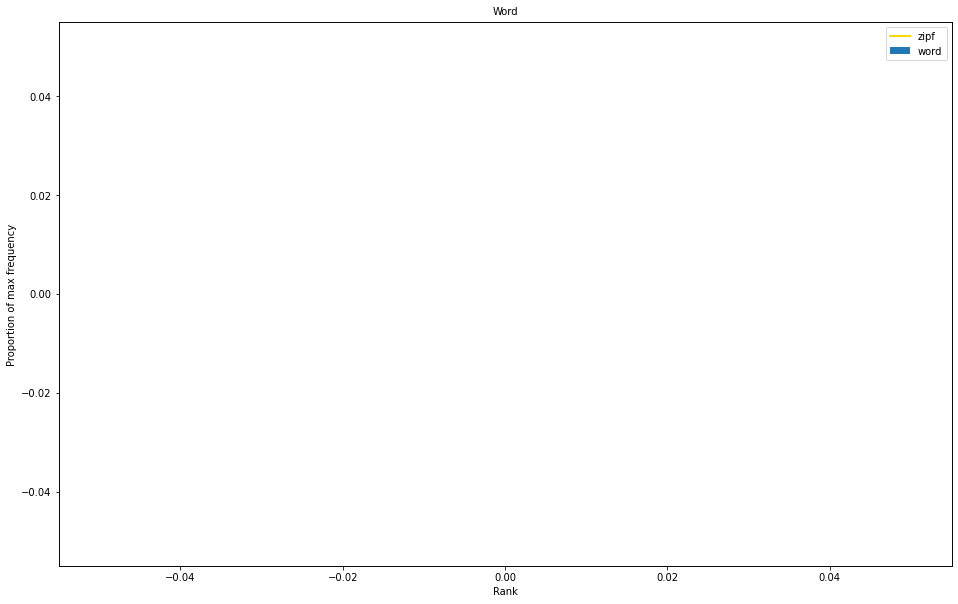

In [19]:
from juxtorpus.features.zipf import Zipf
from spacy.lang.en.stop_words import STOP_WORDS

A_zipf = Zipf(A).set_top(30)
with A_zipf.remove_words(STOP_WORDS) as A_zipff:
    A_zipff.render()

[WARNING] Plotting 30 words may lag as there is a lot to render. Try a number < 25 with set_top()


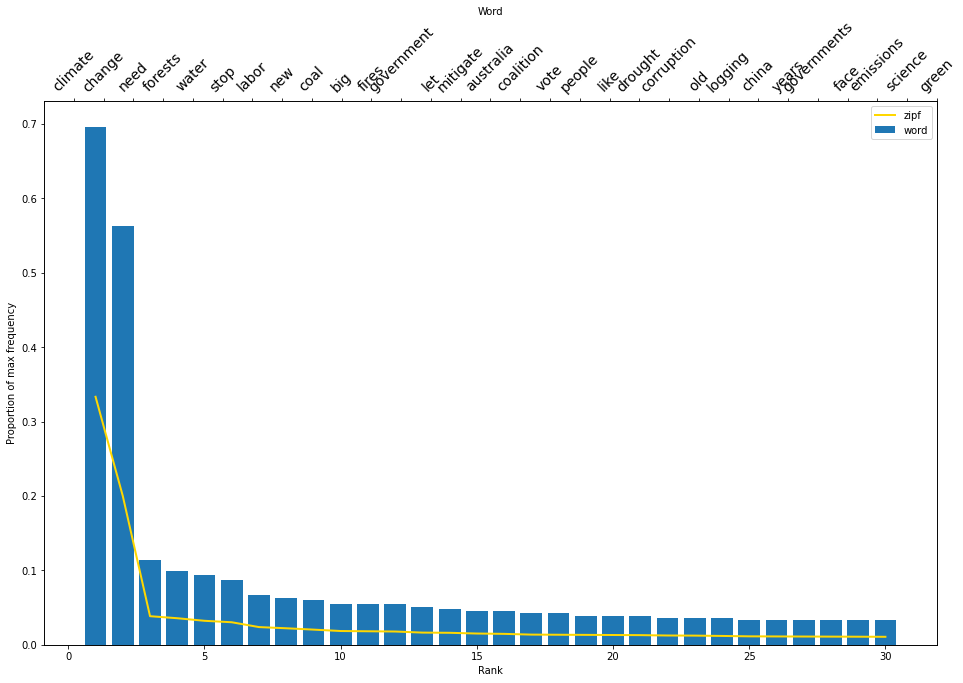

In [20]:
B_zipf = Zipf(B).set_top(30)
with B_zipf.remove_words(STOP_WORDS) as B_zipff:
    B_zipff.render()

# Keywords

Keywords (1-gram) scores are based on term frequencies.
The equation is...
1. term_freq
2. if normalised = term_freq / num_words_in_corpus
3. if log = log(term_freq) / log(num_words_in_corpus)

In [21]:
from juxtorpus.features.keywords import TFKeywords
# A = Sunshine Coast
# B = Broken Hill

# climate climate climate climate
A_tf = TFKeywords(A).freq_threshold(2).normalise(True).log_freqs(False)
B_tf = TFKeywords(B).freq_threshold(2).normalise(True).log_freqs(False)
list(zip(A_tf.extracted()[:10], B_tf.extracted()[:10]))

[]

## Polarity Word Cloud

There are 2 parts to this word cloud. 
1. The colour of the words show the polarity towards either corpus. 

**(Here RED = Sunshine Coast, BLUE = Broken Hill)**

2. The size of the words are highly polarised AND make frequent words that are in **BOTH** corpus smaller.

the score is calculated as abs(relative)/summed.

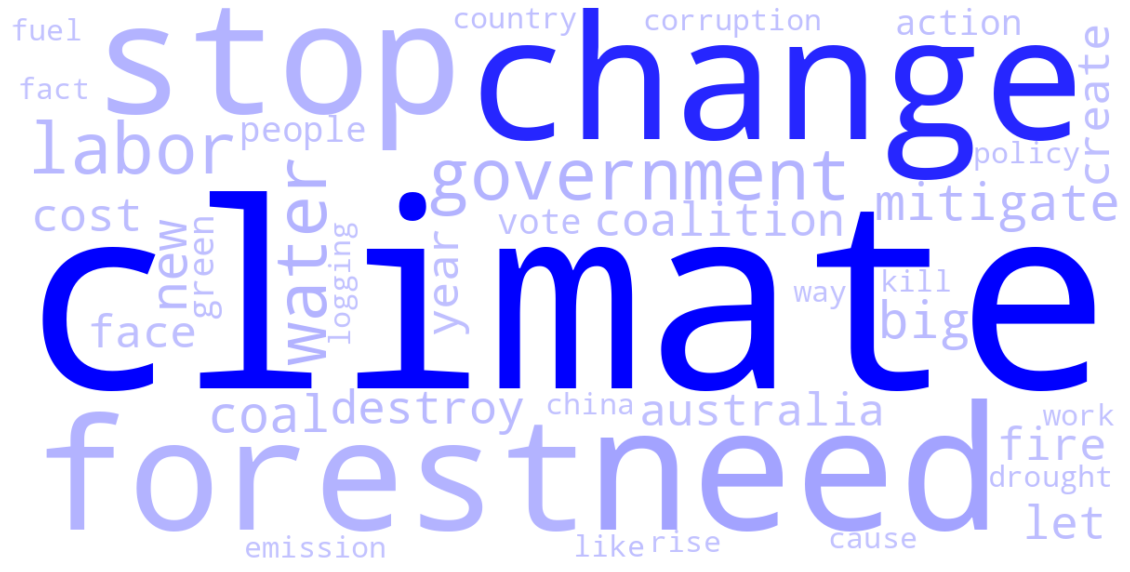

In [22]:
from juxtorpus.viz.polarity_wordcloud import PolarityWordCloud

pwc = PolarityWordCloud.from_(A_tf.extracted(), B_tf.extracted())
pwc.top(40).gradate('red', 'blue').render(20, 32)

In [23]:
pwc._df.head(40).sort_values(by='relative_div_summed_', ascending=False)

,score_A,score_B,relative_,summed_,relative_div_summed_,relative_mul_summed_,relative_normalised_
word,,,,,,,
climate,0,2.923280,-2.923280,2.923280,1.0,8.545568,1.000000
change,0,2.367725,-2.367725,2.367725,1.0,5.606121,1.095023
action,0,0.185185,-0.185185,0.185185,1.0,0.034294,1.468326
green,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588
vote,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588
corruption,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588
kill,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588
drought,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588
country,0,0.171958,-0.171958,0.171958,1.0,0.029569,1.470588


<AxesSubplot:xlabel='word'>

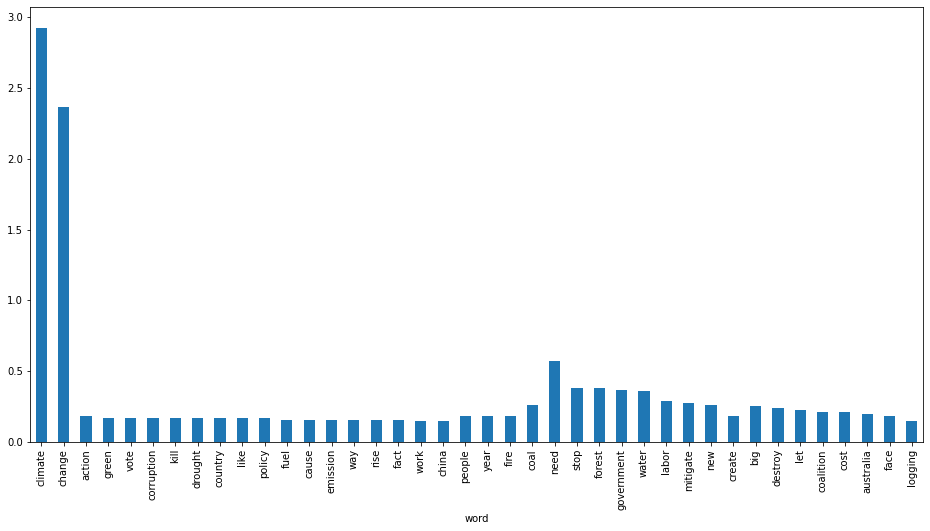

In [24]:
pwc._df.head(40).sort_values(by='relative_div_summed_', ascending=False).summed_.plot.bar(figsize=(16, 8))

<AxesSubplot:xlabel='word'>

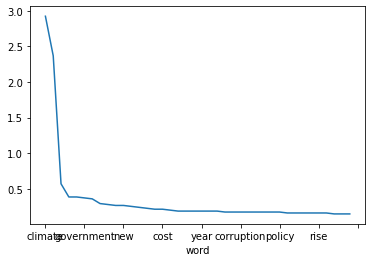

In [25]:
pwc._df.head(40)['summed_'].plot()

<AxesSubplot:xlabel='word'>

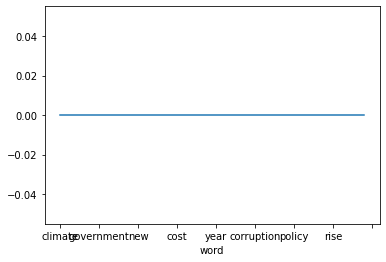

In [26]:
pwc._df.head(40)['score_A'].plot()

In [27]:
corpus.get_meta('extract_hashtags')

<DocMeta [Id: extract_hashtags, Attribute: hashtags]